# Titanic — EDA and Feature Engineering

This notebook performs exploratory data analysis (EDA) and basic feature engineering on the Titanic dataset located at `../data/Titanic-Dataset.csv`. It produces a cleaned, preprocessed dataset suitable for modeling and saves the processed data to `../data/processed_titanic.csv`.

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
pd.options.display.max_columns = 200
sns.set(style="whitegrid")

In [2]:
# Load data
fn = '../data/Titanic-Dataset.csv'
df = pd.read_csv(fn)
print('Loaded', fn, '->', df.shape)
df.head()

Loaded ../data/Titanic-Dataset.csv -> (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# Quick overview: info and describe
df.info()

# Numeric summary
df.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Braund, Mr. Owen Harris",male,NaN,NaN,NaN,347082,NaN,G6,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


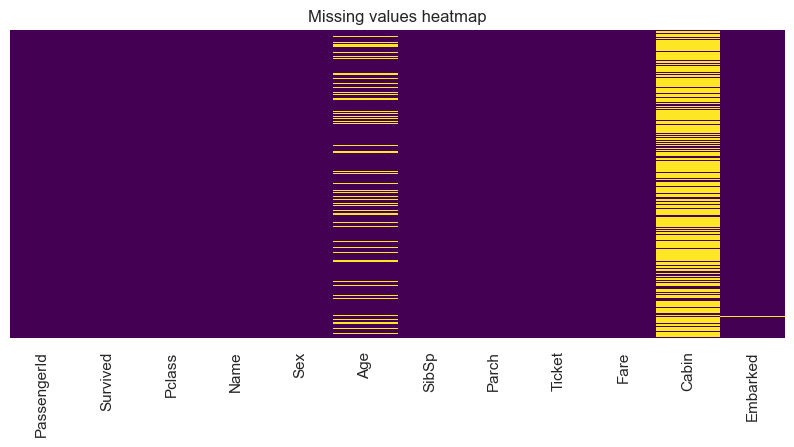

In [4]:
# Missing values summary
missing = df.isna().sum().sort_values(ascending=False)
missing = missing[missing > 0]
missing

# Heatmap of missing values
plt.figure(figsize=(10,4))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title('Missing values heatmap')
plt.show()

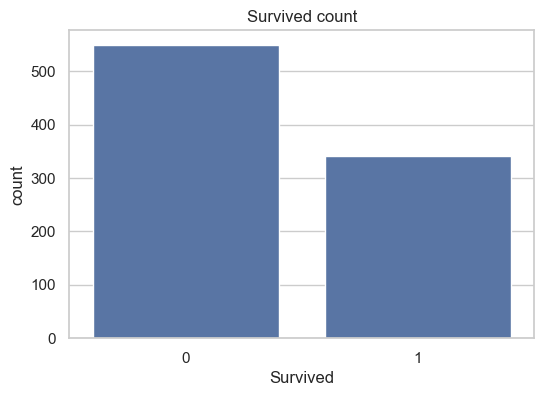

Survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64

In [5]:
# Target distribution
plt.figure(figsize=(6,4))
sns.countplot(x='Survived', data=df)
plt.title('Survived count')
plt.show()
df['Survived'].value_counts(normalize=True)

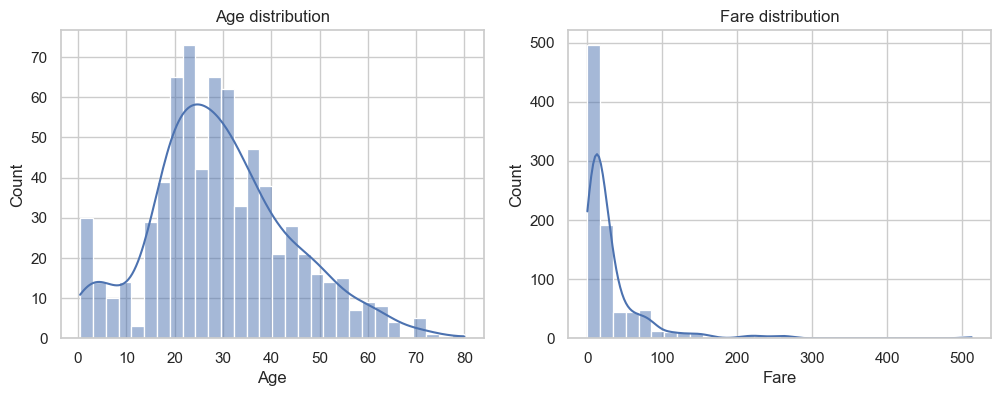

In [6]:
# Numeric distributions: Age and Fare
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(df['Age'].dropna(), bins=30, kde=True)
plt.title('Age distribution')
plt.subplot(1,2,2)
sns.histplot(df['Fare'].dropna(), bins=30, kde=True)
plt.title('Fare distribution')
plt.show()

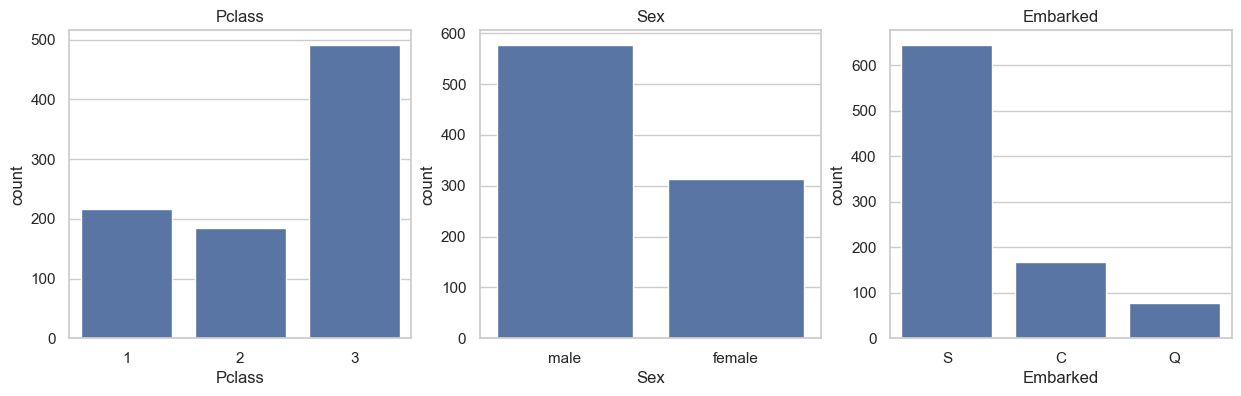

In [7]:
# Categorical counts: Pclass, Sex, Embarked
fig, axes = plt.subplots(1,3, figsize=(15,4))
sns.countplot(x='Pclass', data=df, ax=axes[0])
axes[0].set_title('Pclass')
sns.countplot(x='Sex', data=df, ax=axes[1])
axes[1].set_title('Sex')
sns.countplot(x='Embarked', data=df, ax=axes[2])
axes[2].set_title('Embarked')
plt.show()

## Feature engineering
We'll create a few features often useful for Titanic models:
- Title (from Name)
- FamilySize = SibSp + Parch + 1
- IsAlone (FamilySize == 1)
- Fill missing Age, Embarked, Fare
- Map Sex to binary and OneHot-encode Embarked and Pclass if needed
- Create Age and Fare bins (optional)

In [11]:
# Work on a copy
df2 = df.copy()
# Extract Title from Name
df2['Title'] = df2['Name'].str.extract(',\s*([^\.]+)\.', expand=False)

# Simplify titles
title_map = {
    'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs',
    'Lady':'Royal', 'Countess':'Royal', 'Capt':'Officer', 'Col':'Officer','Major':'Officer','Sir':'Royal','Don':'Royal','Jonkheer':'Royal', 'Dona':'Royal'
}
df2['Title'] = df2['Title'].replace(title_map)
# Family size and IsAlone
df2['FamilySize'] = df2['SibSp'] + df2['Parch'] + 1
df2['IsAlone'] = (df2['FamilySize'] == 1).astype(int)
# Fill Embarked with mode, Fare with median (for missing)
df2['Embarked'] = df2['Embarked'].fillna(df2['Embarked'].mode()[0])
df2['Fare'] = df2['Fare'].fillna(df2['Fare'].median())
# Age will be imputed later in pipeline; for quick checks fill with median now
df2['Age_filled_quick'] = df2['Age'].fillna(df2['Age'].median())
# Map Sex to binary for quick viewing
df2['Sex_bin'] = df2['Sex'].map({'male':0, 'female':1})
df2[['Title','FamilySize','IsAlone','Embarked','Fare','Age_filled_quick','Sex_bin']].head()

,Title,FamilySize,IsAlone,Embarked,Fare,Age_filled_quick,Sex_bin
0,Mr,2,0,S,7.2500,22.0,0
1,Mrs,2,0,C,71.2833,38.0,1
2,Miss,1,1,S,7.9250,26.0,1
3,Mrs,2,0,S,53.1000,35.0,1
4,Mr,1,1,S,8.0500,35.0,0


In [12]:
# Build a sklearn preprocessing pipeline (numeric impute+scale, categorical one-hot)
target = 'Survived'
y = df2[target].values
# Select features to keep - keep core columns and engineered ones
features = ['Pclass','Sex','Age','Fare','Embarked','Title','FamilySize','IsAlone']
X = df2[features].copy()

numeric_features = ['Age','Fare','FamilySize']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_features = ['Pclass','Sex','Embarked','Title','IsAlone']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
    ],
    remainder='drop'
)

# Fit-transform the data to get processed features
X_processed = preprocessor.fit_transform(X)
print('Processed shape:', X_processed.shape)
# If you want a DataFrame of processed features (approx):
cat_cols = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)
num_cols = numeric_features
processed_cols = list(num_cols) + list(cat_cols)
df_processed = pd.DataFrame(X_processed.toarray() if hasattr(X_processed, 'toarray') else X_processed, columns=processed_cols, index=df2.index)
df_processed[target] = y
df_processed.head()

Processed shape: (891, 22)


,Age,Fare,FamilySize,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Rev,Title_Royal,Title_the Countess,IsAlone_0,IsAlone_1,Survived
0,-0.565736,-0.502445,0.059160,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
1,0.663861,0.786845,0.059160,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1
2,-0.258337,-0.488854,-0.560975,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
3,0.433312,0.420730,0.059160,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1
4,0.433312,-0.486337,-0.560975,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0


In [13]:
# Save processed data to CSV for modeling
out_fn = '../data/processed_titanic.csv'
df_processed.to_csv(out_fn, index=False)
print('Saved processed dataset to', out_fn)

Saved processed dataset to ../data/processed_titanic.csv


## How to run
1. Open this notebook in Jupyter or VS Code notebooks.
2. Run all cells top-to-bottom. It expects the original CSV at `../data/Titanic-Dataset.csv`.
3. After running, `../data/processed_titanic.csv` will contain the processed features ready for modeling.

Next steps: try a simple classifier (Logistic Regression, RandomForest) with cross-validation, add more feature interactions, and run hyperparameter search.